A common use case in probabilistic programming is that we want to infer the
likelihood that a certain random variable will take a specific value. Pyro lets
us do this easily for any site.

In [21]:
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import torch

Suppose we want to weigh objects with a faulty
scale that has some measurement noise. This follows a simple Gaussian model:

$$ measurement | weight \sim \mathcal{N}(weight, 0.75) $$

In [22]:
def make_dist(weight, noise):
    return dist.Normal(weight, noise)

weight, noise = 8, 0.75
scale_dist = make_dist(weight, noise)
measurement_1 = pyro.sample("measurement_1", scale_dist)
prob = scale_dist.log_prob(measurement_1).exp()
print(f"measurement: {measurement_1};\t probability: {prob}")

measurement: 9.647275924682617;	 probability: 0.04767860472202301


In [19]:
def make_model_1():
    def model_1(weight):
        y = pyro.sample("measurement", dist.Normal(weight, 0.75))
        return y
    return model_1

weight_1 = 8
measurement_1 = make_model_1()(weight_1)
print(measurement_1)

tensor(8.9977)


Here we took an object with a true weight of 8 and got some noisy measurement.
We then evaluated the probability of observing that measurement. We can easily
use this functionality to plot the PDF of our faulty scale and the object.

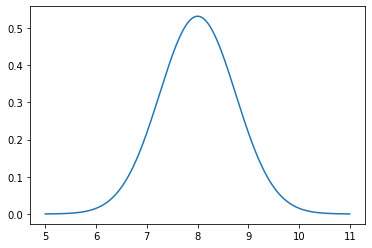

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f0ccdc92550> (for post_execute):


KeyboardInterrupt: 

In [23]:
lb = weight - noise * 4
ub = weight + noise * 4
resolution = 1000
measurements = torch.arange(lb, ub, (ub - lb) / resolution)
probs = scale_dist.log_prob(measurements).exp()
plt.plot(measurements, probs)
plt.show()
ones = torch.ones(10000)
multiscale_dist = make_dist(weight * ones, noise * ones)
samples = pyro.sample("sample", multiscale_dist)
plt.hist(samples, bins=100, density=True)
plt.show()